# Problem Description

* Given data of Actor and movies in which actor acted, We wanted to **group similar movies together** and **group similar Actors together**
* We will form this as a **graph problem**, We will build **[bipartite Graph](https://en.wikipedia.org/wiki/Bipartite_graph)** from **sets of actors and sets of movies**, and use graph algorithms to form implicit embeddings  for every node ( movies and actors )
* We will then user **clustering** methods to **cluster similar movies and actors**

# Load Library

In [14]:
# !pip install stellargraph

import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec


# Load Dataset

In [7]:
data=pd.read_csv('../input/movie-actors/movie_actor_network.csv', index_col=False, names=['movie','actor'])
data.head()

,movie,actor
0,m1,a1
1,m2,a1
2,m2,a2
3,m3,a1
4,m3,a3


## Formulate Problem as A Graph

In [8]:
## get All edges
edges = [tuple(x) for x in data.values.tolist()]


In [9]:
# create graph

graph = nx.Graph()
graph.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
graph.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
graph.add_edges_from(edges,label='acted')


In [10]:
connected_components = [graph.subgraph(c) for c in nx.connected_components(graph)]
print("Total Number of connected components in graph ", len(connected_components))
for subgraph  in  connected_components:
    print("number of nodes", subgraph.number_of_nodes())
    print("number of edges", subgraph.number_of_edges())

graph = connected_components[0]

Total Number of connected components in graph  1
number of nodes 4703
number of edges 9650


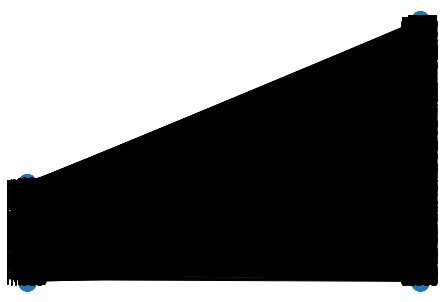

In [11]:
movie_set, actor_set = nx.bipartite.sets(graph)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(movie_set))
pos.update((node, (2, index)) for index, node in enumerate(actor_set))
nx.draw(graph, pos=pos, with_labels=True)
# it's very hard to see, but we can see this is very dense graph
plt.show()

In [12]:
movies=[]
actors=[]

for node in graph.nodes:
    if 'm' in node:
        movies.append(node)
    else:
        actors.append(node)
        
print("Total Number Unique of Movies", len(movies))

print("Total Number of Unique Actors", len(actors))

Total Number Unique of Movies 1292
Total Number of Unique Actors 3411


# Generate Node Embedding using [Representation Learning](https://stellargraph.readthedocs.io/en/stable/demos/embeddings/metapath2vec-embeddings.html?highlight=UniformRandomMetaPathWalk)
* We will use  random walks to get embeddings for all the movies and actors, we will user [metapath2Vec](https://ericdongyx.github.io/papers/KDD17-dong-chawla-swami-metapath2vec.pdf) algorithm
## Metapath2Vec algorithm
The Metapath2Vec algorithm introduced in  [metapath2Vec](https://ericdongyx.github.io/papers/KDD17-dong-chawla-swami-metapath2vec.pdf)  is a 2-step representation learning algorithm. The two steps are:

1. Use **uniform random walks**  to generate **sentences from a graph**. A sentence is a list of node IDs. The **set** of all sentences makes a **corpus**. The **random walk** is driven by a metapath that defines the **node type order by which the random walker explores the graph**.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node ID is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The **Word2Vec** algorithm is used for **calculating the embedding vectors.**
* Two possible Random Walk Model 
    1. [ Movie, Actor, Movie ]
    2. [ Actor, Movie, Actor ]
* We will do **100 random walks** and use randomwalks to **generate embedding using genism** 


In [13]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(graph))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(graph.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [20]:
from gensim.models import Word2Vec
# walks is random walks sequence
# vector_size= embedding length
# window : window size to use in W2V model
model = Word2Vec(walks, vector_size=128, window=5)
print("Shape ",model.wv.vectors.shape)

Shape  (4703, 128)


In [33]:
node_ids = model.wv.index_to_key # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ graph.nodes[node_id]['label'] for node_id in node_ids]